# ANEXO 04

## Estudio de la serie temporal

### Carga de paquetes

In [1]:
# General
import pandas as pd
import numpy as np
from scipy import stats #Contiene las pruebas de normalidad entre otras
#from math import log #Función de logaritmos
#--------------------------------------------------

# Gráficos
import matplotlib.pyplot as plt
#-------------------------------------------------

# TS: Serie temporal
from statsmodels.tsa.seasonal import seasonal_decompose # Descomposición de la serie temporal

from statsmodels.graphics.tsaplots import plot_acf #ACF
from statsmodels.graphics.tsaplots import plot_pacf #PACF
from statsmodels.tsa.stattools import adfuller # Test de estacionalidad

from statsmodels.tsa.arima.model import ARIMA # Modelo Arima con componmente estacional
from statsmodels.tsa.statespace.sarimax import SARIMAX # Modelo Arima con componmente estacional

from pmdarima.arima import auto_arima # Modelo autoarima
#-------------------------------------------------

# Eliminamos los warnings del notebook
import warnings
warnings.filterwarnings('ignore')

### Cargamos el dataset y lo preparamos para el analisis

In [2]:
# Cargamos el archivo guardado previamente en el entorno y guardamos una copia
%store -r df_temporal_series_aggregated_by_date
df = df_temporal_series_aggregated_by_date.copy() 

# Seleccionamos la variable objetivo y reiniciamos el indice
data = df[['fecha_semanas', 'Altas M']]
data.set_index('fecha_semanas', inplace=True)

## Comenzamos la exploración
### Estudio de Estacionaridad y estacionalidad

<AxesSubplot:xlabel='fecha_semanas'>

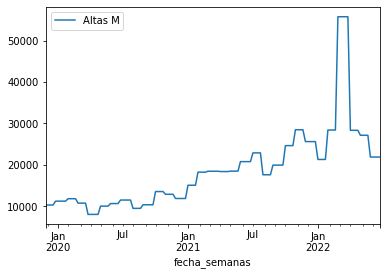

In [3]:
data.plot()

Para tener más información al respecto pasamos a descomponer la serie temporal, lo haremos de forma multiplicativa, dado que consideramos que la magnitud de las fluctuaciones estacionales de la serie varía proporcionalmente con los cambios de tendencia.

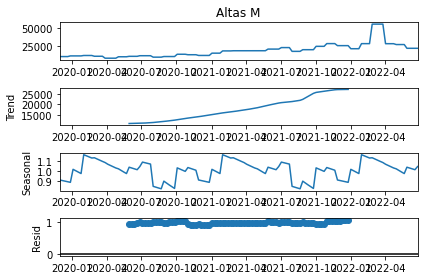

In [4]:
descomposicion=seasonal_decompose(data['Altas M'], model='multiplicative') 
descomposicion.plot();

A simple vista parece una serie no estacionaria, porque se ve un incremento paulatino conforme pasa el tiempo, además también observamos una mayor variabilidad de los datos cara al final de la serie. también se detectan diferencias estacionales, habiendo un crecimiento en el número de contratos a principio de año, acompañados de una bajada, lo cual se repite a mitad de año con una menor intensidad.

De todas formas, para asegurarnos de la estacionariedad de la serie, vamos a realizar la prueba de Dickey-Fuller aumentada (ASSF Test) la cual tiene como hipótesis nula la estacionariedad, como vemos más abajo, la prueba presenta un valor p de 0.42 > 0.05, lo que implica que no podemos rechazar la hipótesis nula, por lo que no encontramos evidencia de que sea no estacionaria, lo que dificulta la capacidad predictiva del modelo.

In [5]:
(adfuller(data))[1]

0.42164296338731333

También es interesante estudiar la normalidad de los residuos, en este caso podemos ver que los residuos no se encuentran evidencias de normalidad en los datos (ambos valores p son menores de 0.05 por lo que rechazamos la hipótesis nula de normalidad), lo cual es una mala noticia, la normalidad implicaría asemejar a un ruido blanco gaussiano, el cual es modelizable.

In [6]:
stats.shapiro(descomposicion._resid.dropna())


ShapiroResult(statistic=0.9647338390350342, pvalue=0.02235090546309948)

In [7]:
stats.kstest(descomposicion._resid.dropna(), 'norm')


KstestResult(statistic=0.8165761026504601, pvalue=5.0327184454127626e-61)

Hemos comprobado que la descomposición, no es suficiente para limpiar los datos, por lo que vamos a pasar a una limpieza más profunda.

## Limpieza de la serie temporal
### Heterocedastidad

<AxesSubplot:xlabel='fecha_semanas'>

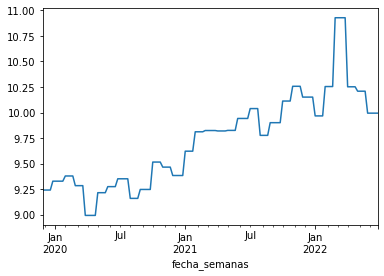

In [8]:
data_clean_h = data.copy()
data_clean_h['Altas M'] = np.log(data['Altas M'])
data_clean_h['Altas M'].plot()

### Tendencia

<AxesSubplot:xlabel='fecha_semanas'>

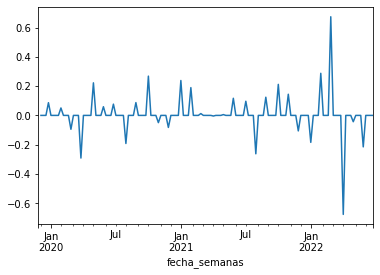

In [9]:
data_clean_ht = data_clean_h.copy()
data_clean_ht['Altas M'] = data_clean_h['Altas M'] - data_clean_h['Altas M'].shift(1)
data_clean_ht['Altas M'].dropna(inplace=True)
data_clean_ht['Altas M'].plot()

### Estacionalidad

<AxesSubplot:xlabel='fecha_semanas'>

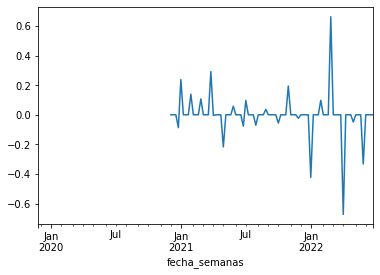

In [10]:
data_clean_hte = data_clean_ht.copy()
data_clean_hte['Altas M'] = data_clean_ht['Altas M'] - data_clean_ht['Altas M'].shift(52)
data_clean_hte['Altas M'].dropna(inplace=True)
data_clean_hte['Altas M'].plot()

In [11]:
data_clean_hte.dropna(inplace=True)
stats.shapiro(data_clean_hte['Altas M'])

ShapiroResult(statistic=0.5380415320396423, pvalue=1.1854553051541573e-14)

In [12]:
stats.kstest(data['Altas M'], 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

Tras tratar los datos, vemos que seguimos sin tener errores normales. Vistos los resultados del análisis, concluimos que debemos descartar los métodos de suavizado, debido a que no estacionaria ni en media ni en varianza. Esto también descarta los modelos AR y MA, por lo que recurriremos a modelos ARIMA dado que los procesos no estacionarios más importantes, son los integrados.

## Modelo ARIMA

Vamos a empezar por el estudio de la función de autocorrelación simple (ACF) y la función de autocorrelación parcial (PACF) mediante el uso de correlogramas. Este estudio nos permitirá por un lado para comprobar si la serie es estacionaria (anteriormente hemos visto que no lo era), y por otro lado estudiar los procesos AR y MA.

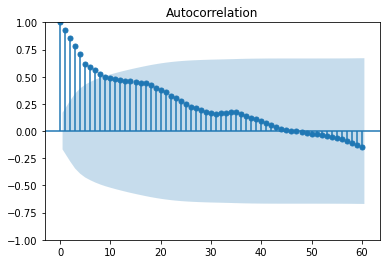

In [13]:
plot_acf(data['Altas M'], lags = 60);

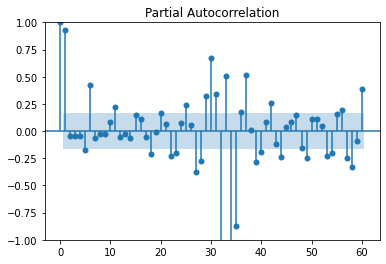

In [14]:
plot_pacf(data['Altas M'], lags = 60);

Del Estudio del ACF, podemos ver un decrecimiento progresivo claro, lo cual, como ya sospechábamos, es indicio de no estacionariedad, también vemos que no se aprecia ningún corte en la serie, lo que en indicativo de MA(0). También se pueden apreciar unos ligeros picos cada 17 semanas, lo cual nos indica que podemos estudiar la parte estacional con retardo 17 (es decir, cada aproximadamente 4 meses). Como es no estacionario, no puedo basarme en el ACF, para estudiar el componente, AR, pero en el PACF, encontramos dos valores seguidos significativos, lo que parece indicar un AR(2). A continuación, comprobamos el componente I, del modelo, se puede ver que con I = 1 es suficiente para que la serie sea estacionaria.

In [15]:
(adfuller((data['Altas M'] - data['Altas M'].shift(1)).dropna()))[1]

4.681651483504349e-06

De momento, todo parece apuntar a un modelo ARIMA (2, 1, 0) en lo regular, vamos a comprobar la parte estacional. Para ello miraremos los gráficos de la serie diferenciada con un retardo de 17.

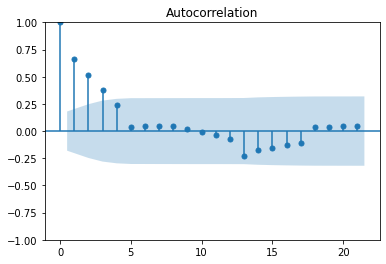

In [16]:
plot_acf((data['Altas M'] - data['Altas M'].shift(17)).dropna());

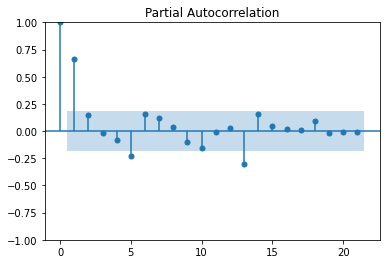

In [17]:
plot_pacf((data['Altas M'] - data['Altas M'].shift(17)).dropna());

Al igual que antes el ACF vemos un decrecimiento continuo sin grandes cortes, lo que nos lleva a pensar por un lado en la no estacionariedad, si bien existen cortes pequeños por lo que requerirá un análisis más profundo de la serie y por otro, un MA(0). En el PACF podemos ver un AR de orden 2 igual que antes. A continuación, hemos estudiado el componente I, de la serie en lo estacional y se puede ver que la series ya es estacionaria sin necesidad de diferenciar, por lo que I = 0

In [18]:
datadif = (data['Altas M'] - data['Altas M'].shift(17)).dropna()

(adfuller((datadif).dropna()))[1]


0.029750361533521518

Con todo este estudio, concluimos que vamos a probar 2 modelos, dado que la estacionalidad no es muy clara, probaremos primero un ARIMA(2,1,0) y luego aplicaremos un modelo ARIMA(2,1,0)(2,1,0)<sub>17</sub>

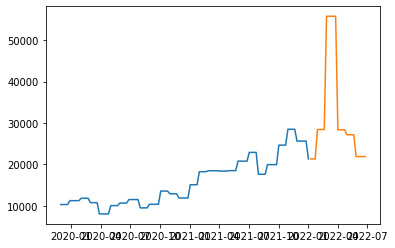

In [19]:
train = data[:110]
test = data[110:]
plt.plot(train)
plt.plot(test)

In [20]:
arima_model = ARIMA(train, order=(2,1,0))
model = arima_model.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                Altas M   No. Observations:                  110
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -927.978
Date:                Thu, 22 Sep 2022   AIC                           1861.955
Time:                        15:59:56   BIC                           1870.029
Sample:                    11-30-2019   HQIC                          1865.229
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1        2.36e-05   1064.256   2.22e-08      1.000   -2085.904    2085.904
ar.L2       2.379e-05   1055.229   2.25e-08      1.000   -2068.211    2068.211
sigma2       1.48e+06   9.54e+04     15.515      0.0

In [21]:
sarima_model = SARIMAX(train, order=(2,1,0), seasonal_order=(2, 0, 0, 17), trend = 'ct')
model_s = sarima_model.fit()
print(model_s.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49395D+00    |proj g|=  2.40745D-01

At iterate    5    f=  8.41684D+00    |proj g|=  1.06310D-03

At iterate   10    f=  8.41666D+00    |proj g|=  6.61428D-03


 This problem is unconstrained.



At iterate   15    f=  8.41662D+00    |proj g|=  6.21560D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     19      1     0     0   6.216D-05   8.417D+00
  F =   8.4166182458632157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                            Altas M   No. Observations:                  110
Model:             SARIMAX(2, 1, 0)x(2, 0, 0, 17)   Log Likelihood                -925.828
Date:                            Thu, 22 Sep 2022   AIC                           1865.6

Para comparar los modelos podemos utilizar algunas de las muchas métricas de error o indicadores clave de rendimiento (KPI) disponibles.  Hemos implementado algunas de las métricas de error de rendimiento más utilizadas, como la raíz del cuadrado medio (RMSE), el error medio absoluto (MAE), el error medio porcentual (MPE), el error medio porcentual absoluto (MAPE) y el coeficiente de correlación (para medir la similitud). En este caso concreto, las métricas más útiles son MAPE Y MASE, esto es debido a que en el caso de los modelos de series temporales, los valores cambian con el tiempo y las métricas como MAE o RMSE no captan fácilmente la escala de los valores. El MAE encuentra la diferencia absoluta entre los valores predichos y los reales y los promedia sobre todas las muestras del conjunto de pruebas. Con el tiempo, el cambio de valores se pierde, y el contexto de los valores reales del conjunto también es significativo. Por ejemplo, un MAE de 100 sería una buena puntuación si los valores reales son del orden de 10.000, pero una puntuación terrible si los valores se sitúan en los cientos. Lo mismo ocurre con el RMSE. Sin embargo, el MAPE es independiente de la escala y es fiable para una serie temporal tan cambiante siempre que el valor no llegue nunca a 0; de lo contrario, la puntuación será indefinida. La mejor alternativa es el error medio absoluto a escala o MASE según el consenso general (Hyndman, 2006) dado que considera los datos con los que se ha entrenado el modelo en forma de cambios o diferencias de primer orden, esto hace que sea una buena medida para los datos de series temporales, independientemente de la escala o el tiempo.

In [22]:
def model_statistics(y_pred, y_true):

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
    mae = np.mean(np.abs(y_pred - y_true))
    mpe = np.mean((y_pred - y_true)/y_true)
    rmse = np.mean((y_pred - y_true)**2)**.5

    n = np.array(test).shape[0]
    d = np.abs(np.diff(np.array(y_true))).sum()/(n-1)
    mase = mae/d

    corr = np.corrcoef(y_pred, y_true)[0,1]

    print({'mape': mape, 'mae': mae, 'mpe': mpe, 'rmse': rmse, 'mase': mase,'corr': corr})

In [23]:
y_pred = pd.Series(model.forecast(25)[0], index= test.index)
y_true = pd.Series(test['Altas M'].to_list(), index= test.index)

model_statistics(y_pred, y_true)

{'mape': 0.24307968309936961, 'mae': 10205.60175102414, 'mpe': -0.24307968309936961, 'rmse': 16094.531537311268, 'mase': 3.5840961383769847, 'corr': nan}


In [24]:
y_pred = pd.Series(model_s.forecast(25)[0], index= test.index)
y_true = pd.Series(test['Altas M'].to_list(), index= test.index)

model_statistics(y_pred, y_true)

{'mape': 0.23804634104056976, 'mae': 10047.961244884707, 'mpe': -0.23571111458688324, 'rmse': 15963.830517385108, 'mase': 3.52873451021533, 'corr': nan}


Tanto en el caso el MAPE como en el del MASE aquel modelo con un valor más bajo en estos índices será el modelo más riguroso, podemos apreciar como el modelo ARIMA(2,1,0)(2,1,0)<sub>17</sub> presenta unos mejores valores. A continuación, vamos a probar una autoarima para buscar un mejor rendimiento a partir de este.

In [ ]:
model_auto = auto_arima(train,start_p=2, start_q=0,
max_p=3, max_d=3, max_q=3, start_P=2,
start_Q=0, max_P=3, max_D= 3,
max_Q= 3, m=17, seasonal=True,
error_action='warn',trace = True,
supress_warnings=True,stepwise = False,
random_state=7654, n_fits = 50)

In [26]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  110
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 17)   Log Likelihood                -926.013
Date:                            Thu, 22 Sep 2022   AIC                           1858.025
Time:                                    16:00:58   BIC                           1866.099
Sample:                                11-30-2019   HQIC                          1861.300
                                     - 01-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    100.9469    124.408      0.811      0.417    -142.888     344.782
ar.S.L17       0.1718      0.054      3.195      0.001       0.066       0.277
sigma2      1.443e+06   9.25e+04     15.598      0.000    1.26e+06    1.62e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               294.51
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
predictiontotest = pd.DataFrame(model_auto.predict(n_periods = 25),index=test.index)
predictiontotest.columns = ['Altas M']

y_pred = pd.Series(predictiontotest['Altas M'].to_list(), index= test.index)
y_true = pd.Series(test['Altas M'].to_list(), index= test.index)

model_statistics(y_pred, y_true)

{'mape': 0.21682250275106132, 'mae': 9136.182502289965, 'mpe': -0.17360384260774456, 'rmse': 14755.715307180883, 'mase': 3.2085277502307847, 'corr': 0.24155809636807693}


Este modelo presenta unos peores índices que el anterior. Vamos a probar otro autoarima prefijando el valor de D a 1, dado que en el ACF se da indicios de que no es estacionario, por cubrir todas las posibilidades.

In [ ]:
model_autod1 = auto_arima(train, 
start_p=2, d=1, start_q=0,
max_p=3, max_d=3, max_q=3, 
start_P=2, start_Q=0, D = 1, 
max_P=3, max_D= 3, max_Q= 3, 
m=17, seasonal=True,
error_action='warn',trace = True,
supress_warnings=True,stepwise = True,
random_state=123, n_fits = 25)


In [31]:
model_autod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  110
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 17)   Log Likelihood                -782.980
Date:                              Thu, 22 Sep 2022   AIC                           1569.959
Time:                                      16:03:55   BIC                           1575.003
Sample:                                  11-30-2019   HQIC                          1571.995
                                       - 01-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L17      -0.4318      0.151     -2.857      0.004      -0.728      -0.136
sigma2      1.432e+06   9.73e+04     14.710      0.000    1.24e+06    1.62e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):               225.82
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               4.18   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
predictiontotest = pd.DataFrame(model_autod1.predict(n_periods = 25),index=test.index)
predictiontotest.columns = ['Altas M']

y_pred = pd.Series(predictiontotest['Altas M'].to_list(), index= test.index)
y_true = pd.Series(test['Altas M'].to_list(), index= test.index)


model_statistics(y_pred, y_true)

{'mape': 0.21524180102301763, 'mae': 8556.727720856456, 'mpe': -0.111836745593993, 'rmse': 13290.779982202379, 'mase': 3.0050295445231683, 'corr': 0.4288392846139302}


Este modelo presenta los mejores índices hasta el momento, vamos a pintar las predicciones para los próximos años y compararlo el test.

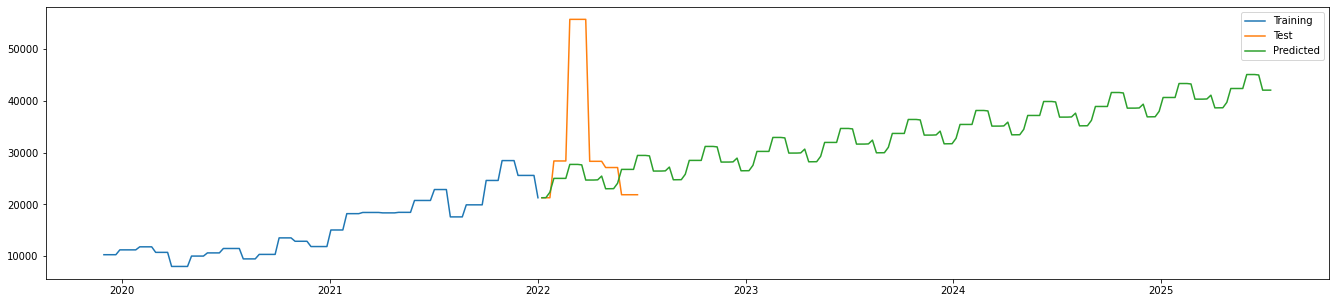

In [30]:
prediction = pd.DataFrame(model_autod1.predict(n_periods = 184))

plt.figure(figsize=(23,5))
plt.plot(train,label='Training')
plt.plot(test['Altas M'],label='Test')
plt.plot(prediction,label='Predicted')
plt.legend(loc = 'best')
plt.show()

Podemos ver que el periodo de test ha tenido un crecimiento y decrecimiento anormal de los datos, pero vemos que el modelo se ajusta de manera aproximada a lo esperable dado el historial de la serie.